# Lab 3: Galaxy Morphology Classification with CNNs

In this lab, you'll build a CNN to classify **galaxy morphology** from images. Given a 64x64 color image of a galaxy, your model will predict its shape: smooth and round, cigar-shaped, edge-on disk, or spiral.

**Your tasks** (in `cnn.py`):
1. Design and implement a `CNN` class — any architecture you like
2. Implement `train_step()` — a single gradient descent update with cross-entropy loss
3. Train your model, then **save the parameters** with `save_model(params)`

**Grading (4 points):**
- **1 pt:** `train_step` works correctly (loss decreases)
- **1 pt:** Saved model achieves **>70%** test accuracy
- **2 pts:** Saved model achieves **>80%** test accuracy

Data: [GalaxyMNIST](https://github.com/mwalmsley/galaxy_mnist) (Walmsley et al.), from Galaxy Zoo DECaLS.

In [1]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
import optax
import flax.linen as nn

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.size"] = 12

CLASS_NAMES = ["Smooth round", "Smooth cigar", "Edge-on disk", "Spiral"]

from cnn import N_CLASSES

---
## Part A: The Data

We use images from the [Galaxy Zoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/) citizen science project, where volunteers classify galaxy morphologies. The images come from the DECaLS sky survey.

**4 classes:**
- **0 — Smooth round:** Elliptical galaxies with no visible structure
- **1 — Smooth cigar:** Elongated ellipticals
- **2 — Edge-on disk:** Disk galaxies viewed from the side
- **3 — Spiral:** Face-on spirals with visible arm structure

The images are 64x64 RGB, normalized to [0, 1].

In [ ]:
# Load pre-processed galaxy data
data = np.load("galaxy_data.npz")

# Convert uint8 -> float32 in [0, 1]
X_train = data["X_train"].astype(np.float32) / 255.0
X_val = data["X_val"].astype(np.float32) / 255.0
X_test = data["X_test"].astype(np.float32) / 255.0
y_train, y_val, y_test = data["y_train"], data["y_val"], data["y_test"]

print(f"Train: {X_train.shape}")
print(f"Val:   {X_val.shape}")
print(f"Test:  {X_test.shape}")
print(f"\nClass distribution (train):")
for c in range(N_CLASSES):
    print(f"  {CLASS_NAMES[c]:16s}: {int((y_train == c).sum())}")

Train: (2000, 64, 64, 3)
Val:   (1000, 64, 64, 3)
Test:  (500, 64, 64, 3)

Class distribution (train):
  Smooth round    : 471
  Smooth cigar    : 495
  Edge-on disk    : 541
  Spiral          : 493


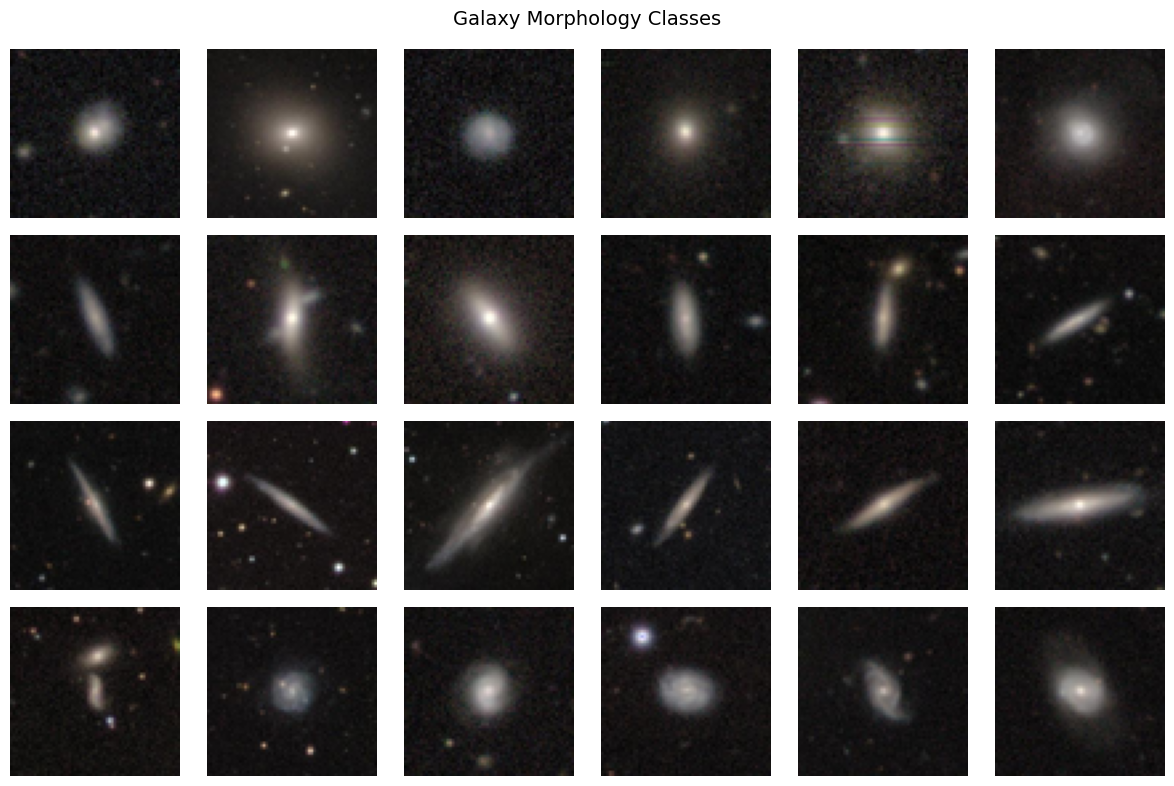

In [ ]:
# Visualize examples from each class
fig, axes = plt.subplots(4, 6, figsize=(12, 8))

for row, c in enumerate(range(N_CLASSES)):
    idxs = np.where(y_train == c)[0][:6]
    for col, idx in enumerate(idxs):
        axes[row, col].imshow(X_train[idx])
        axes[row, col].axis("off")
        if col == 0:
            axes[row, col].set_ylabel(CLASS_NAMES[c], fontsize=10, rotation=0, labelpad=80, va="center")

plt.suptitle("Galaxy Morphology Classes", fontsize=14)
plt.tight_layout()
plt.show()

---
## Part B: Build the CNN (TODO #1)

Open `cnn.py` and implement the `CNN` class. Your network must:
- **Input:** `(batch, 64, 64, 3)` — RGB galaxy images
- **Output:** `(batch, 4)` — logits for each class (no softmax!)

**You're free to choose any architecture.** A standard pattern:

```
Conv -> activation -> Pool  (repeat 2-4 times)
  -> Flatten -> Dense -> activation -> Dense(4)
```

### Flax API quick reference

```python
# Convolution: 32 output channels, 3x3 kernel
x = nn.Conv(features=32, kernel_size=(3, 3))(x)  # default padding is 'SAME'

# Batch normalization (helps with deeper networks)
x = nn.BatchNorm(use_running_average=True)(x)

# Activations
x = nn.relu(x)

# Pooling: 2x2 window, stride 2 (halves spatial dimensions)
x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

# Flatten: (batch, H, W, C) -> (batch, H*W*C)
x = x.reshape((x.shape[0], -1))

# Fully connected
x = nn.Dense(features=128)(x)

# Final layer: 4 classes
x = nn.Dense(features=4)(x)
```

In [ ]:
# Define the CNN model and training step -- add your implementation to cnn.py
from cnn import CNN, load_model, save_model, train_step

In [ ]:
# Test: verify your CNN has the right input/output contract
model = CNN()
key = jr.PRNGKey(0)

dummy_input = jnp.ones((4, 64, 64, 3))
params = model.init(key, dummy_input)
logits = model.apply(params, dummy_input)

n_params = sum(p.size for p in jax.tree.leaves(params))

print(f"Input shape:  {dummy_input.shape}")
print(f"Output shape: {logits.shape}")
print(f"Parameters:   {n_params:,}")

assert logits.shape == (4, N_CLASSES), f"Expected (4, {N_CLASSES}), got {logits.shape}"
print("\nShape check passed!")

Input shape:  (4, 64, 64, 3)
Output shape: (4, 4)
Parameters:   548,516

Shape check passed!


---
## Part C: Implement the Training Step (TODO #2)

Now implement `train_step()` in `cnn.py`. This is multi-class classification, so we use **softmax cross-entropy** instead of MSE.

You'll need:
- `model.apply(params, X_batch)` to get logits
- `optax.softmax_cross_entropy_with_integer_labels` for the loss
- `jax.value_and_grad` to get loss and gradients in one call
- `optimizer.update` and `optax.apply_updates` to update parameters

In [ ]:
# Test: verify train_step works and loss decreases
model = CNN()
key = jr.PRNGKey(0)

X_batch = jnp.array(X_train[:64])
y_batch = jnp.array(y_train[:64])

params = model.init(key, X_batch)
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

losses = []
for i in range(10):
    params, opt_state, loss = train_step(params, opt_state, X_batch, y_batch, model, optimizer)
    losses.append(float(loss))

print(f"Loss: {losses[0]:.4f} -> {losses[-1]:.4f}")
assert np.isfinite(losses[-1]), "Loss is not finite!"
assert losses[-1] < losses[0], f"Loss did not decrease: {losses[0]:.4f} -> {losses[-1]:.4f}"
print("train_step check passed!")

Loss: 1.4049 -> 0.9868
train_step check passed!


---
## Part D: Train, Evaluate, and Save

The training loop below trains your CNN for 10 epochs with Adam (lr=1e-3) and batch size 64. After training, **save your model** so the autograder can evaluate it.

This basic loop should get you to ~70%. To reach 80%, you'll need to modify the training loop. Think about what properties of galaxy images you can exploit.

In [ ]:
# Training loop (modify this to improve accuracy!)
model = CNN()
key = jr.PRNGKey(42)

X_train_jax = jnp.array(X_train)
y_train_jax = jnp.array(y_train)
X_val_jax = jnp.array(X_val)
y_val_jax = jnp.array(y_val)

params = model.init(key, X_train_jax[:1])
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

jit_train_step = jax.jit(lambda p, o, x, y: train_step(p, o, x, y, model, optimizer))

n_epochs = 10
batch_size = 64
n_train = len(X_train_jax)
rng = np.random.default_rng(0)

train_losses = []
val_accs = []

for epoch in range(n_epochs):
    idx = rng.permutation(n_train)
    epoch_losses = []

    for start in range(0, n_train, batch_size):
        batch_idx = idx[start : start + batch_size]
        params, opt_state, loss = jit_train_step(params, opt_state, X_train_jax[batch_idx], y_train_jax[batch_idx])
        epoch_losses.append(float(loss))

    val_logits = model.apply(params, X_val_jax)
    val_acc = float((val_logits.argmax(-1) == y_val_jax).mean())

    train_losses.append(np.mean(epoch_losses))
    val_accs.append(val_acc)

    print(f"Epoch {epoch + 1:2d}/{n_epochs} — loss: {np.mean(epoch_losses):.4f}, val acc: {val_acc:.2%}")

Epoch  1/10 — loss: 1.3256, val acc: 39.20%
Epoch  2/10 — loss: 1.0604, val acc: 57.60%
Epoch  3/10 — loss: 0.8374, val acc: 65.20%
Epoch  4/10 — loss: 0.7080, val acc: 65.70%
Epoch  5/10 — loss: 0.6385, val acc: 67.70%
Epoch  6/10 — loss: 0.5628, val acc: 69.40%
Epoch  7/10 — loss: 0.4995, val acc: 71.30%
Epoch  8/10 — loss: 0.4647, val acc: 69.40%
Epoch  9/10 — loss: 0.4383, val acc: 70.70%
Epoch 10/10 — loss: 0.3658, val acc: 71.40%


In [ ]:
# Save your trained model -- the autograder loads this file!
save_model(params)
print("Model saved to model_params.pkl")

Model saved to model_params.pkl


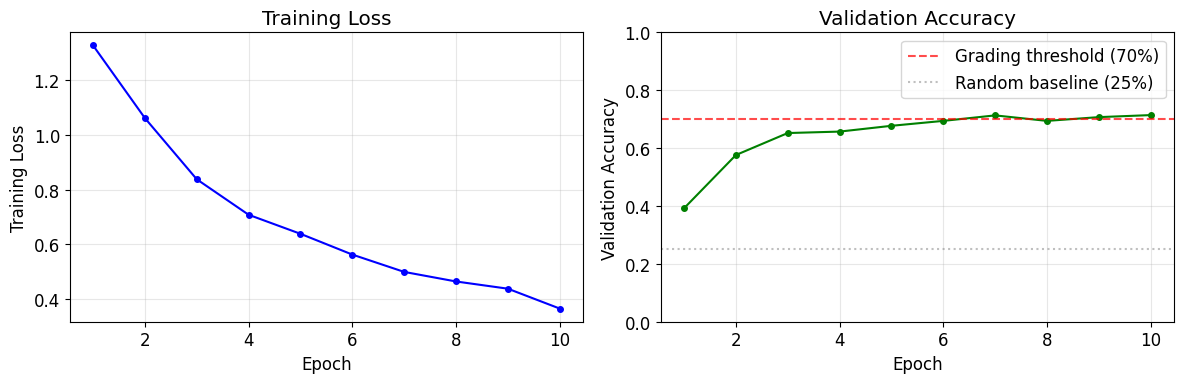

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(range(1, n_epochs + 1), train_losses, "b-o", markersize=4)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Training Loss")
axes[0].set_title("Training Loss")
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, n_epochs + 1), val_accs, "g-o", markersize=4)
axes[1].axhline(y=0.70, color="r", linestyle="--", alpha=0.7, label="Grading threshold (70%)")
axes[1].axhline(y=0.25, color="gray", linestyle=":", alpha=0.5, label="Random baseline (25%)")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation Accuracy")
axes[1].set_title("Validation Accuracy")
axes[1].set_ylim(0, 1.0)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on held-out test set
X_test_jax = jnp.array(X_test)
y_test_jax = jnp.array(y_test)

test_logits = model.apply(params, X_test_jax)
test_preds = test_logits.argmax(-1)
test_acc = float((test_preds == y_test_jax).mean())

print(f"Test accuracy: {test_acc:.2%}")

# Per-class accuracy
print("\nPer-class accuracy:")
for c in range(N_CLASSES):
    mask = y_test == c
    class_acc = float((np.array(test_preds)[mask] == c).mean())
    print(f"  {CLASS_NAMES[c]:16s}: {class_acc:.2%} ({int(mask.sum())} samples)")

Test accuracy: 73.00%

Per-class accuracy:
  Smooth round    : 86.40% (125 samples)
  Smooth cigar    : 87.05% (139 samples)
  Edge-on disk    : 40.32% (124 samples)
  Spiral          : 76.79% (112 samples)


In [ ]:
# === SELF-CHECK ===
# This replicates the autograder.

print("Running autograder checks...\n")

# Check 1: Loss decreases (1 pt)
if losses[-1] < losses[0]:
    print("[PASS] (1 pt) Loss decreased during training")
else:
    print(f"[FAIL] (1 pt) Loss did not decrease: {losses[0]:.4f} -> {losses[-1]:.4f}")

# Check 2 & 3: Saved model accuracy
try:
    loaded_params = load_model()
    loaded_logits = model.apply(loaded_params, X_test_jax)
    loaded_acc = float((loaded_logits.argmax(-1) == y_test_jax).mean())

    if loaded_acc > 0.70:
        print(f"[PASS] (1 pt) Saved model accuracy {loaded_acc:.2%} > 70%")
    else:
        print(f"[FAIL] (1 pt) Saved model accuracy {loaded_acc:.2%} < 70%")

    if loaded_acc > 0.80:
        print(f"[PASS] (2 pts) Saved model accuracy {loaded_acc:.2%} > 80%")
    else:
        print(f"[FAIL] (2 pts) Saved model accuracy {loaded_acc:.2%} < 80%")
except Exception as e:
    print(f"[FAIL] Could not load saved model: {e}")
    print("       Make sure you ran save_model(params) after training.")

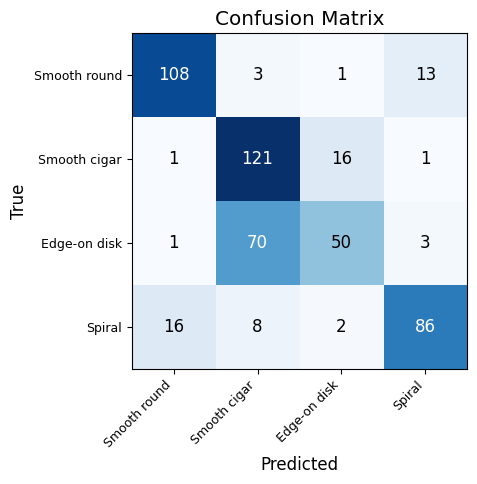

In [ ]:
# Confusion matrix
from collections import Counter

conf = np.zeros((N_CLASSES, N_CLASSES), dtype=int)
for true, pred in zip(np.array(y_test_jax), np.array(test_preds)):
    conf[true, pred] += 1

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(conf, cmap="Blues")
for i in range(N_CLASSES):
    for j in range(N_CLASSES):
        ax.text(
            j, i, str(conf[i, j]), ha="center", va="center", color="white" if conf[i, j] > conf.max() / 2 else "black"
        )

ax.set_xticks(range(N_CLASSES))
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha="right", fontsize=9)
ax.set_yticks(range(N_CLASSES))
ax.set_yticklabels(CLASS_NAMES, fontsize=9)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

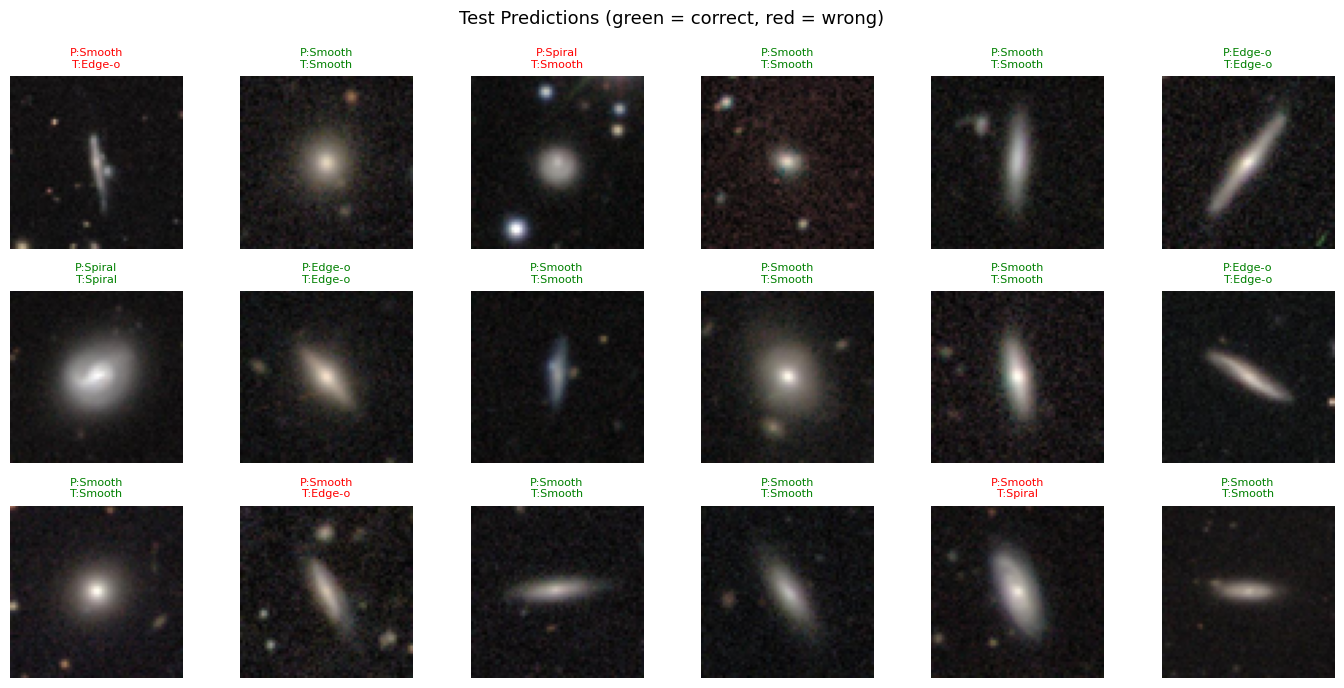

In [ ]:
# Show some predictions
fig, axes = plt.subplots(3, 6, figsize=(14, 7))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i])
    pred = int(test_preds[i])
    true = int(y_test[i])
    correct = pred == true
    color = "green" if correct else "red"
    ax.set_title(f"P:{CLASS_NAMES[pred][:6]}\nT:{CLASS_NAMES[true][:6]}", color=color, fontsize=8)
    ax.axis("off")

plt.suptitle("Test Predictions (green = correct, red = wrong)", fontsize=13)
plt.tight_layout()
plt.show()